In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [105]:
df = pd.read_csv("../Data/Copy of hackathon_customerData_challenge2.csv")
df.head()

,customerID,Date_UTC,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C
0,793,2022-10-21T18:00:00.000Z,2022-10-22,15,4099.0,NaN
1,793,2022-10-21T18:15:00.000Z,2022-10-22,15,5566.0,NaN
2,793,2022-10-21T18:30:00.000Z,2022-10-22,16,3565.5,NaN
3,793,2022-10-21T18:45:00.000Z,2022-10-22,16,3420.5,NaN
4,793,2022-10-21T19:00:00.000Z,2022-10-22,17,3236.5,NaN


In [106]:
# Drop rows where laod power is 0
df = df[df['load_power_W'] != 0.0]

In [107]:
# Convert date column from str to datetime
df['Date_UTC'] = pd.to_datetime(df['Date_UTC'])

In [ ]:
def delete_rows_before_midnight(customer_id):
    # chosen_id = (df['customerID'] == customer_id) 
    # timestamps = df.loc[chosen_id, 'Date_NZDT']
    # first_midnight_occurrence = timestamps[timestamps.dt.time == pd.Timestamp('00:00:00').time()].head(1)
    # df['customerID'] = df['customerID'][first_midnight_occurrence:]

    #Duplicates the df columns for removing every row before midnight 
    result_df = pd.DataFrame(columns=df.columns)
    for customer_id, group in df.groupby('customerID'):
        midnight_index = group[group['Date_UTC'].dt.time == pd.Timestamp('00:00:00').time()].index.min()
        result_df = pd.concat([result_df, group.loc[midnight_index:]])

    return result_df
# Delete rows before the first midnight occurrence for each customer
df_filtered = delete_rows_before_midnight(df)

# Update the original DataFrame 'df' with the modified 'df_filtered'
df = df_filtered.copy()

In [108]:
df['Date_NZDT'] = df['Date_UTC'] + pd.Timedelta(hours=13)
df.insert(2, 'Date_NZDT', df.pop('Date_NZDT'))
df.head()

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN


In [109]:
# Spring = 0
# Summer = 1
# Autumn = 2
# Winter = 3

def get_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 0
    elif month in [6, 7, 8]:
        return 1
    elif month in [9, 10, 11]:
        return 2
    else:
        return 3

# Assuming 'Date_NZDT' is your date column
df['Season'] = df['Date_NZDT'].apply(get_season)
df.head()

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C,Season
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN,2
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN,2
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN,2
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN,2
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN,2


In [110]:
df['average_temp'] = df.groupby(['customerID', 'Date_NZDate'])['weather_Temp_C'].transform(np.mean)
df

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C,Season,average_temp
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN,2,NaN
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN,2,NaN
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN,2,NaN
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN,2,NaN
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN,2,NaN
...,...,...,...,...,...,...,...,...,...
35038979,592,2023-08-24 18:00:00+00:00,2023-08-25 07:00:00+00:00,2023-08-25,13,261.5,0.800,1,6.173474
35038980,592,2023-08-24 18:15:00+00:00,2023-08-25 07:15:00+00:00,2023-08-25,13,459.0,-0.035,1,6.173474
35038981,592,2023-08-24 18:30:00+00:00,2023-08-25 07:30:00+00:00,2023-08-25,14,359.0,-0.870,1,6.173474
35038982,592,2023-08-24 18:45:00+00:00,2023-08-25 07:45:00+00:00,2023-08-25,14,488.0,-1.370,1,6.173474


In [111]:
def day(num):
    return slice((num - 1) * 96, num * 96 + 1)

day(1)

slice(0, 97, None)

383160   NaN
383161   NaN
383162   NaN
383163   NaN
383164   NaN
          ..
383252   NaN
383253   NaN
383254   NaN
383255   NaN
383256   NaN
Name: weather_Temp_C, Length: 97, dtype: float64


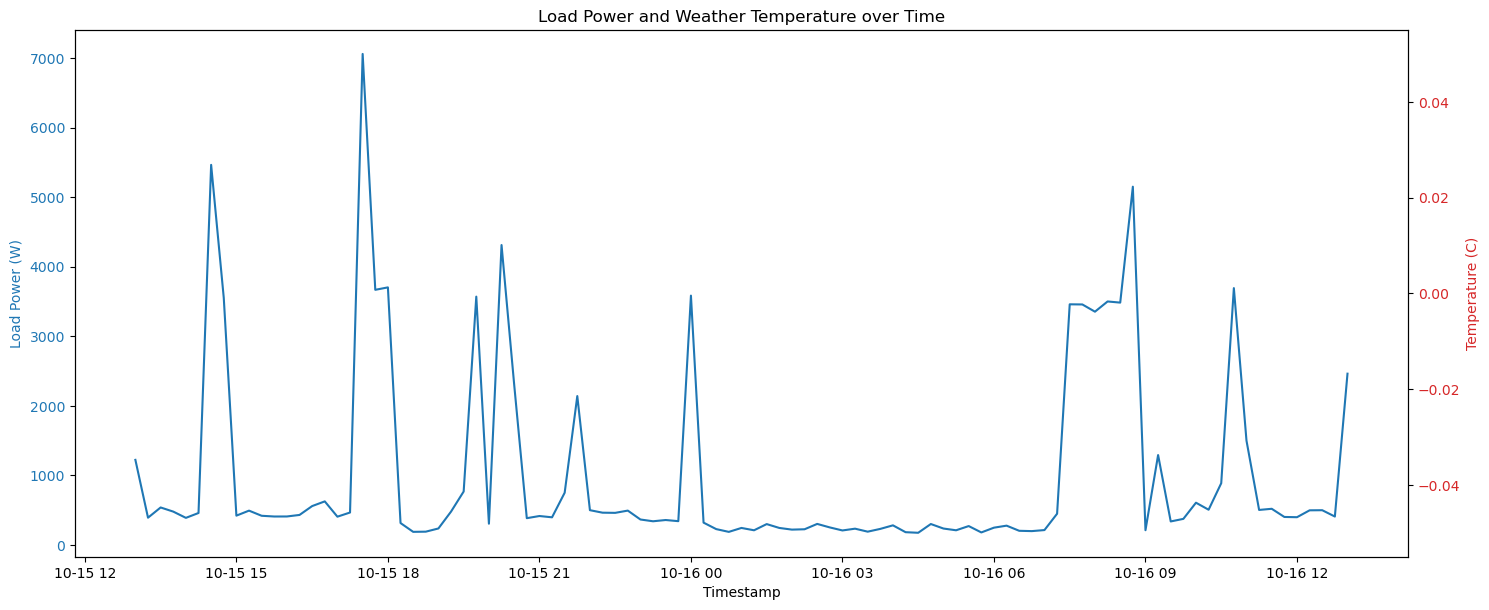

        customerID                  Date_UTC                 Date_NZDT  \
383160         850 2022-10-15 00:00:00+00:00 2022-10-15 13:00:00+00:00   
383161         850 2022-10-15 00:15:00+00:00 2022-10-15 13:15:00+00:00   
383162         850 2022-10-15 00:30:00+00:00 2022-10-15 13:30:00+00:00   
383163         850 2022-10-15 00:45:00+00:00 2022-10-15 13:45:00+00:00   
383164         850 2022-10-15 01:00:00+00:00 2022-10-15 14:00:00+00:00   
383165         850 2022-10-15 01:15:00+00:00 2022-10-15 14:15:00+00:00   
383166         850 2022-10-15 01:30:00+00:00 2022-10-15 14:30:00+00:00   
383167         850 2022-10-15 01:45:00+00:00 2022-10-15 14:45:00+00:00   
383168         850 2022-10-15 02:00:00+00:00 2022-10-15 15:00:00+00:00   
383169         850 2022-10-15 02:15:00+00:00 2022-10-15 15:15:00+00:00   

       Date_NZDate  date_settlementPeriod  load_power_W  weather_Temp_C  \
383160  2022-10-15                     27        1221.5             NaN   
383161  2022-10-15                 

In [112]:
def plot_customer_data(customer_id, day_num):
    df_customer = df[df['customerID'] == customer_id]
    
    fig, ax1 = plt.subplots(figsize=(15, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Load Power (W)', color=color)
    ax1.plot(df_customer['Date_NZDT'][day(day_num)], df_customer['load_power_W'][day(day_num)], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Temperature (C)', color=color)  # we already handled the x-label with ax1
    print(df_customer['weather_Temp_C'][day(day_num)])
    ax2.plot(df_customer['Date_NZDT'][day(day_num)], df_customer['weather_Temp_C'][day(day_num)], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Load Power and Weather Temperature over Time')
    plt.show()

plot_customer_data(850, 1)

print(df[df['customerID'] == 850][0:10])

In [113]:
df.columns

Index(['customerID', 'Date_UTC', 'Date_NZDT', 'Date_NZDate',
       'date_settlementPeriod', 'load_power_W', 'weather_Temp_C', 'Season',
       'average_temp'],
      dtype='object')

<Axes: >

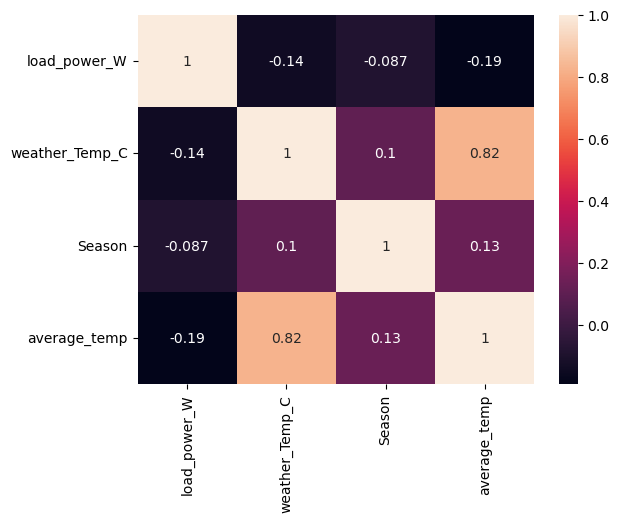

In [116]:
# Assuming df is your DataFrame
correlation_matrix = df[['load_power_W', 'weather_Temp_C', 'Season', 'average_temp']].corr()
sns.heatmap(correlation_matrix, annot=True)


In [115]:
print(type(df['Date_UTC'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


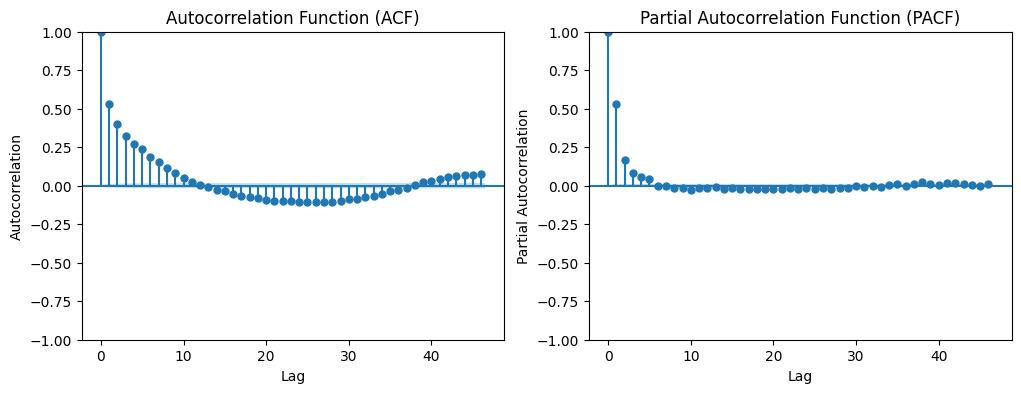

C:\Users\charu\AppData\Local\Temp\ipykernel_20844\2955475821.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer['Date_UTC'] = pd.to_datetime(df_customer['Date_UTC'])
C:\Users\charu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\charu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self

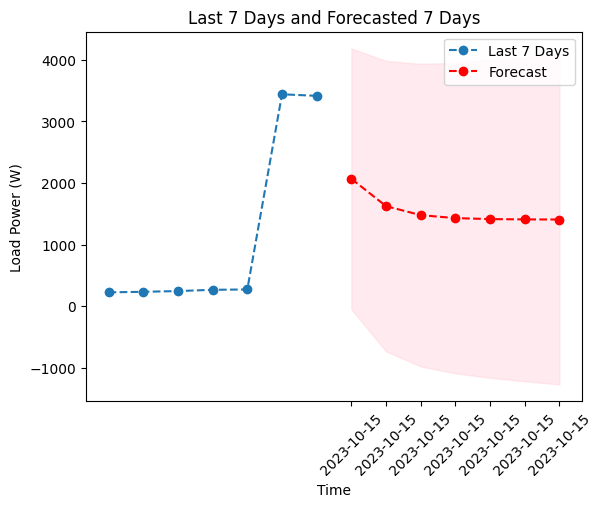

In [66]:
##CHECKING IF DATA IS STATIONARY USING ADF TEST
# Assuming 'df' is your DataFrame with the time series data
# def stationary_check_power(column_header):
#     # Perform Augmented Dickey-Fuller test
#     result = adfuller(column_header)
    
#     # Check for stationarity based on the p-value
#     if result[1] > 0.05:
#         df = df.diff().dropna()

# stationary_check_power(df['load_power_W'])


df_customer = df[df['customerID'] == 173]
result = adfuller(df_customer['load_power_W'])

# Check for stationarity based on the p-value
if result[1] > 0.05:
    df_customer = df_customer.diff().dropna()
#Visualize your data using ACF and PACF plots.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_customer['load_power_W'], ax=ax[0])
plot_pacf(df_customer['load_power_W'], ax=ax[1])

#Labelling the axes
# Label the axes
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_title('Autocorrelation Function (ACF)')

ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()

df_customer['Date_UTC'] = pd.to_datetime(df_customer['Date_UTC'])
#Fit ARIMA model:
p, d, q = 1, 1, 1  # Example values
model = ARIMA(df_customer['load_power_W'], order=(p, d, q))
results = model.fit()

#Make Predictions:  
#Steps is in days 
forecast = results.get_forecast(steps=7)

# plt.plot(df_customer['Date_UTC'].tail(7), df_customer['load_power_W'].tail(7), label='Last 7 Days', linestyle='--', marker='o')
# plt.plot(pd.date_range(df_customer['Date_UTC'].max(), periods=7 + 1, freq='15T')[1:], forecast.predicted_mean, label='Forecast', color='red', linestyle='--', marker='o')

# # Access the index of the original time series data
# last_date = df_customer['Date_UTC'].max()
# index_for_forecast = pd.date_range(start=last_date, periods= 7, freq='15T')
# # Use the modified index to fill between the confidence intervals
# plt.fill_between(index_for_forecast, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
# # Set the x-axis ticks to match the dates
# plt.xticks(index_for_forecast, rotation=45)


# Visualize the last 7 days of the original series and the forecasted 7 days.
last_7_days = df_customer['Date_UTC'].tail(7)
plt.plot(last_7_days, df_customer['load_power_W'].tail(7), label='Last 7 Days', linestyle='--', marker='o')
forecast_dates = pd.date_range(last_7_days.max(), periods=7 + 1, freq='15T')[1:]
plt.plot(forecast_dates, forecast.predicted_mean, label='Forecast', color='red', linestyle='--', marker='o')

# Use the modified index to fill between the confidence intervals
plt.fill_between(forecast_dates, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)

# Set the x-axis ticks to match the dates
plt.xticks(forecast_dates, rotation=45)


# Label the axes
plt.xlabel('Time')
plt.ylabel('Load Power (W)')
plt.title('Last 7 Days and Forecasted 7 Days')

plt.legend()
plt.show()